In [1]:
import pandas as pd
import numpy as np
from math import sqrt, ceil
from timeit import timeit, Timer

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rc
import seaborn as sns
from matplotlib.animation import FuncAnimation
from matplotlib.patches import ConnectionPatch
import matplotlib.animation as animation

rc('text', usetex=False)
plt.style.use('seaborn')
%matplotlib inline

legend_opts = {
    'fontsize':12,
    'frameon':True, 
    'framealpha':1,
    'facecolor':'white',
    'edgecolor':'black',
    'labelspacing':0.1}

In [3]:
%load_ext autoreload
%aimport utils
%autoreload 1
from utils import *

In [4]:
%load_ext line_profiler
%load_ext memory_profiler

## Load data

In [5]:
male_scores = pd.read_csv('scores/trimmed_male.csv')
female_scores = pd.read_csv('scores/trimmed_female.csv')

In [6]:
# Randomly choose 10 years for training set, and remaining 4 years for test set
# (which must include the last year 2018 for visualisation purpose)
years_before_last = range(2005, 2018)
year_seed = np.random.RandomState(seed=42)
train_years = sorted(list(year_seed.choice(years_before_last, size=10, replace=False)))
test_years = sorted([year for year in years_before_last if year not in train_years] + [2018])
train_years, test_years

([2005, 2006, 2007, 2009, 2010, 2012, 2013, 2014, 2016, 2017],
 [2008, 2011, 2015, 2018])

In [7]:
all_season_scores = male_scores.loc[male_scores['event']!='WR']
all_world_scores = male_scores.loc[male_scores['event']=='WR']
all_years = range(2005, 2019)

In [8]:
# Create train and test score tables for male skaters
season_train, world_train, season_test, world_test = train_test_split(male_scores, train_years, test_years)
season_train.shape, world_train.shape, season_test.shape, world_test.shape

((1216, 4), (238, 4), (507, 4), (96, 4))

In [9]:
season_scores, world_scores = get_yearly_scores(2017, season_train, world_train)

# Multi-factor matrix factorization

## Small example

In [91]:
# Select relevant rows from male season scores in 2017 for toy example
sample_season_scores = season_scores.loc[[1758, 1760, 1765, 1769, 1771, 1776, 1787]]

In [92]:
# Transform long score table to pivot form
season_pivot = pd.pivot_table(sample_season_scores[['name', 'event', 'score']], values='score', index='name', columns='event')

In [93]:
# Store skater and event names to retrieve later
skater_names = list(season_pivot.index) # ['Alexander, MAJOROV', 'Javier, FERNANDEZ', 'Misha, GE', 'Takahito, MURA']
event_names = list(season_pivot.columns) # ['CA', 'FR', 'RU']

# Convert pivot table to numpy array
true_scores = season_pivot.values 
pd.DataFrame(true_scores).to_csv('viz/multi_true_scores.csv')

### Naive implementation of gradient descent (loop gradient descent over each factor)

1 iteration

In [13]:
# 1. Initialize baseline, event, and skater scores (random number between 0 and 1 given some seed)
n_factors = 2
random_state = np.random.RandomState(seed=42)
baseline = random_state.random_sample()
event_scores = random_state.random_sample((n_factors, len(event_names)))
skater_scores = random_state.random_sample((len(skater_names), n_factors))

In [14]:
# 2a. Calculate residual for every event-skater pair
predicted_scores = skater_scores @ event_scores + baseline
residuals = predicted_scores - true_scores

In [15]:
# 2b. Calculate baseline gradient and update baseline score
alpha = 0.0005
baseline_gradient = np.nansum(residuals)
baseline = baseline - alpha * baseline_gradient
baseline

1.2194162740630508

In [16]:
alpha = 0.0005

# 2c. For each factor k
for k in range(n_factors):
    # i. Calculate gradients for each factor
    skater_scores_k = skater_scores[:, [k]]
    event_scores_k = event_scores[[k], :]   
    
    event_gradients_k = np.nansum(residuals * skater_scores_k, axis=0, keepdims=True)
    skater_gradients_k = np.nansum(residuals * event_scores_k, axis=1, keepdims=True)

    # ii. Update scores for each factor
    event_scores[[k], :] = event_scores_k - alpha * event_gradients_k
    skater_scores[:, [k]] = skater_scores_k - alpha * skater_gradients_k
    
event_scores, skater_scores

(array([[1.0831755 , 0.96952181, 0.78491258],
        [0.26965945, 0.27629043, 0.11856101]]),
 array([[0.92341149, 0.60666815],
        [0.89965097, 0.05125891],
        [1.16008655, 0.86773826],
        [0.40835933, 0.21843853]]))

Many iterations

In [17]:
# Step 1: Initialize baseline score, and scores of all latent factors
random_state = np.random.RandomState(seed=42)
baseline = random_state.random_sample()
event_scores = random_state.random_sample((2, 3))
skater_scores = random_state.random_sample((4, 2))

# Step 2: repeat until convergence
for i in range(1000):
    # a. Calculate residual for every event-skater pair
    predicted_scores = skater_scores @ event_scores + baseline
    residuals = predicted_scores - true_scores
    
    # b. Calculate baseline gradient and update baseline score
    baseline_gradient = np.nansum(residuals)
    baseline = baseline - alpha * baseline_gradient
    
    # c. For each factor k
    for k in range(n_factors):
        # i. Calculate gradients for each factor
        skater_scores_k = skater_scores[:, [k]]
        event_scores_k = event_scores[[k], :]
        
        event_gradients_k = np.nansum(residuals * skater_scores_k, axis=0, keepdims=True)
        skater_gradients_k = np.nansum(residuals * event_scores_k, axis=1, keepdims=True)
        
        # ii. Update scores for each factor
        event_scores[[k], :] = event_scores_k - alpha * event_gradients_k
        skater_scores[:, [k]] = skater_scores_k - alpha * skater_gradients_k
        
    if i in [998, 999]:
        print(f'RMSE: {np.sqrt(np.nanmean(residuals**2))}')

RMSE: 0.0036914387445527892
RMSE: 0.0036496037817914133


In [18]:
pd.DataFrame(skater_scores, index=skater_names)

,0,1
"Alexander, MAJOROV",10.226857,3.122723
"Javier, FERNANDEZ",16.009246,4.594796
"Misha, GE",11.919684,7.280747
"Takahito, MURA",14.059611,3.020423


### Broadcasted implementation of gradient descent

1 iteration

In [19]:
# 1. Initialize baseline, event, and skater scores (random number between 0 and 1 given some seed)
n_factors = 2
random_state = np.random.RandomState(seed=42)
baseline = random_state.random_sample()
event_scores = random_state.random_sample((n_factors, len(event_names)))
skater_scores = random_state.random_sample((len(skater_names), n_factors))

In [20]:
# 2a. Calculate residual for every event-skater pair
predicted_scores = skater_scores @ event_scores + baseline
residuals = predicted_scores - true_scores

In [21]:
# 2b. Calculate baseline gradient and update baseline score
alpha = 0.0005
baseline_gradient = np.nansum(residuals)
baseline = baseline - alpha * baseline_gradient
baseline

1.2194162740630508

In [22]:
# 2c. Calculate gradient and update latent scores for all factors
# Reshape matrices
reshaped_residuals = residuals[np.newaxis, :, :]
reshaped_event_scores = event_scores[:, np.newaxis, :]
reshaped_skater_scores = skater_scores.T[:, :, np.newaxis]

# 2c-i: Calculate gradients for all factors
event_gradients = np.nansum(reshaped_residuals * reshaped_skater_scores, axis=1)
skater_gradients = np.nansum(reshaped_residuals * reshaped_event_scores, axis=2).T

# 2c-ii: Update latent scores for all factors
event_scores = event_scores - alpha * event_gradients
skater_scores = skater_scores - alpha * skater_gradients

event_scores, skater_scores

(array([[1.0831755 , 0.96952181, 0.78491258],
        [0.26965945, 0.27629043, 0.11856101]]),
 array([[0.92341149, 0.60666815],
        [0.89965097, 0.05125891],
        [1.16008655, 0.86773826],
        [0.40835933, 0.21843853]]))

Many iterations

In [23]:
# Initialize baseline score, and scores of all latent factors
random_state = np.random.RandomState(seed=42)
baseline = random_state.random_sample()
event_scores = random_state.random_sample((2, 3))
skater_scores = random_state.random_sample((4, 2))

alpha = 0.0005
# Step 2: repeat until convergence
for i in range(1000):
    # a. Calculate residual for every event-skater pair
    predicted_scores = skater_scores @ event_scores + baseline
    residuals = predicted_scores - true_scores
    
    # b. Calculate baseline gradient and update baseline score
    baseline_gradient = np.nansum(residuals)
    baseline = baseline - alpha * baseline_gradient
    
    # c. Calculate gradient and update latent scores for all factors
    # Reshape matrices
    reshaped_residuals = residuals[np.newaxis, :, :]
    reshaped_event_scores = event_scores[:, np.newaxis, :]
    reshaped_skater_scores = skater_scores.T[:, :, np.newaxis]
    
    # 2c-i: Calculate gradients for all factors
    event_gradients = np.nansum(reshaped_residuals * reshaped_skater_scores, axis=1)
    skater_gradients = np.nansum(reshaped_residuals * reshaped_event_scores, axis=2).T
    
    # 2c-ii: Update latent scores for all factors
    event_scores = event_scores - alpha * event_gradients
    skater_scores = skater_scores - alpha * skater_gradients
        
    if i in [998, 999]:
        print(f'RMSE: {np.sqrt(np.nanmean(residuals**2))}')

RMSE: 0.0036914387445527892
RMSE: 0.0036496037817914133


In [24]:
print(pd.DataFrame(skater_scores, index=skater_names))

                            0         1
Alexander, MAJOROV  10.226857  3.122723
Javier, FERNANDEZ   16.009246  4.594796
Misha, GE           11.919684  7.280747
Takahito, MURA      14.059611  3.020423


### Matrix multiplication implementation

In [140]:
# 1. Initialize baseline, event, and skater scores (random number between 0 and 1 given some seed)
n_factors = 2
random_state = np.random.RandomState(seed=42)
baseline = random_state.random_sample()
event_scores = random_state.random_sample((n_factors, len(event_names)))
skater_scores = random_state.random_sample((len(skater_names), n_factors))

In [141]:
# 2a. Calculate residual for every event-skater pair
predicted_scores = skater_scores @ event_scores + baseline
residuals = predicted_scores - true_scores

In [130]:
# 2b. Calculate baseline gradient and update baseline score
alpha = 0.0005
baseline_gradient = np.nansum(residuals)
baseline = baseline - alpha * baseline_gradient
baseline

1.2194162740630508

In [134]:
residuals = np.nan_to_num(residuals)
residuals

array([[   0.        ,    0.        , -191.21200125],
       [   0.        , -284.48394398, -292.1803706 ],
       [-224.64347614, -227.84563525,    0.        ],
       [-221.52521797, -247.86166524,    0.        ]])

In [107]:
event_gradients = skater_scores.T @ residuals
skater_gradients = residuals @ event_scores.T

# 2c-ii: Update latent scores for all factors
event_scores = event_scores - alpha * event_gradients
skater_scores = skater_scores - alpha * skater_gradients

event_scores, skater_scores

(array([[1.0831755 , 0.96952181, 0.78491258],
        [0.26965945, 0.27629043, 0.11856101]]),
 array([[0.92341149, 0.60666815],
        [0.89965097, 0.05125891],
        [1.16008655, 0.86773826],
        [0.40835933, 0.21843853]]))

In [108]:
# Initialize baseline score, and scores of all latent factors
random_state = np.random.RandomState(seed=42)
baseline = random_state.random_sample()
event_scores = random_state.random_sample((2, 3))
skater_scores = random_state.random_sample((4, 2))

alpha = 0.0005
# Step 2: repeat until convergence
for i in range(1000):
    # a. Calculate residual for every event-skater pair
    predicted_scores = skater_scores @ event_scores + baseline
    residuals = predicted_scores - true_scores
    
    # b. Calculate baseline gradient and update baseline score
    baseline_gradient = np.nansum(residuals)
    baseline = baseline - alpha * baseline_gradient
        
    
    # c-i: Calculate gradients for all factors
    residuals = np.nan_to_num(residuals)
    event_gradients = skater_scores.T @ residuals
    skater_gradients = residuals @ event_scores.T
    
    # c-ii: Update latent scores for all factors
    event_scores = event_scores - alpha * event_gradients
    skater_scores = skater_scores - alpha * skater_gradients
        
    if i in [998, 999]:
        print(f'RMSE: {np.sqrt(np.nanmean(residuals**2))}')

RMSE: 0.002819382911700985
RMSE: 0.0027874309311093745


In [109]:
print(pd.DataFrame(skater_scores, index=skater_names))

                            0         1
Alexander, MAJOROV  10.226857  3.122723
Javier, FERNANDEZ   16.009246  4.594796
Misha, GE           11.919684  7.280747
Takahito, MURA      14.059611  3.020423


## Profiling three methods in comparison

### Time profiling

In [110]:
def naive_gradient_descent(true_scores, n_iter, n_factors):
    alpha = 0.0005
    
    # Initialize baseline score, and scores of all latent factors
    random_state = np.random.RandomState(seed=42)
    baseline = random_state.random_sample()    
    event_scores = random_state.random_sample((n_factors, true_scores.shape[1]))
    skater_scores = random_state.random_sample((true_scores.shape[0], n_factors))


    # Step 2: repeat until convergence
    for i in range(n_iter):
        # a. Calculate residual for every event-skater pair
        predicted_scores = skater_scores @ event_scores + baseline
        residuals = predicted_scores - true_scores

        # b. Calculate baseline gradient and update baseline score
        baseline_gradient = np.nansum(residuals)
        baseline = baseline - alpha * baseline_gradient

        # c. For each factor k
        for k in range(n_factors):
            # i. Calculate gradients for each factor
            skater_scores_k = skater_scores[:, [k]]
            event_scores_k = event_scores[[k], :]

            event_gradients_k = np.nansum(residuals * skater_scores_k, axis=0, keepdims=True)
            skater_gradients_k = np.nansum(residuals * event_scores_k, axis=1, keepdims=True)

            # ii. Update scores for each factor
            event_scores[[k], :] = event_scores_k - alpha * event_gradients_k
            skater_scores[:, [k]] = skater_scores_k - alpha * skater_gradients_k

In [111]:
def broadcast_gradient_descent(true_scores, n_iter, n_factors):
    alpha = 0.0005
    
    # Initialize baseline score, and scores of all latent factors
    random_state = np.random.RandomState(seed=42)
    baseline = random_state.random_sample()
    event_scores = random_state.random_sample((n_factors, true_scores.shape[1]))
    skater_scores = random_state.random_sample((true_scores.shape[0], n_factors))

    # Step 2: repeat until convergence
    for i in range(n_iter):
        # a. Calculate residual for every event-skater pair
        predicted_scores = skater_scores @ event_scores + baseline
        residuals = predicted_scores - true_scores

        # b. Calculate baseline gradient and update baseline score
        baseline_gradient = np.nansum(residuals)
        baseline = baseline - alpha * baseline_gradient

        # c. Calculate gradient and update scores for all factors
        reshaped_residuals = residuals[np.newaxis, :, :]
        reshaped_event_scores = event_scores[:, np.newaxis, :]
        reshaped_skater_scores = skater_scores.T[:, :, np.newaxis]
        event_gradients = np.nansum(residuals * reshaped_skater_scores, axis=1)
        skater_gradients = np.nansum(residuals * reshaped_event_scores, axis=2).T

        event_scores = event_scores - alpha * event_gradients
        skater_scores = skater_scores - alpha * skater_gradients

In [112]:
def matmul_gradient_descent(true_scores, n_iter, n_factors):
    alpha = 0.0005
    
    # Initialize baseline score, and scores of all latent factors
    random_state = np.random.RandomState(seed=42)
    baseline = random_state.random_sample()
    event_scores = random_state.random_sample((n_factors, true_scores.shape[1]))
    skater_scores = random_state.random_sample((true_scores.shape[0], n_factors))

    # Step 2: repeat until convergence
    for i in range(n_iter):
        # a. Calculate residual for every event-skater pair
        predicted_scores = skater_scores @ event_scores + baseline
        residuals = predicted_scores - true_scores

        # b. Calculate baseline gradient and update baseline score
        baseline_gradient = np.nansum(residuals)
        baseline = baseline - alpha * baseline_gradient

        
        # c-i: Calculate gradients for all factors
        residuals = np.nan_to_num(residuals)
        event_gradients = skater_scores.T @ residuals
        skater_gradients = residuals @ event_scores.T

        # c-ii: Update latent scores for all factors
        event_scores = event_scores - alpha * event_gradients
        skater_scores = skater_scores - alpha * skater_gradients

In [113]:
naive_times = []
broadcast_times = []
matmul_times = []
n_factor_values = 10**np.arange(6)

for k in n_factor_values:
    print(f'Factors: {k}')
    print('Naive: ', end='')
    naive_runtimes = %timeit -o naive_gradient_descent(true_scores, 1, k)
    print('Broadcast: ', end='')
    broadcast_runtimes = %timeit -o broadcast_gradient_descent(true_scores, 1, k)
    print('Matmul: ', end='')
    matmul_runtimes = %timeit -o matmul_gradient_descent(true_scores, 1, k)
    
    naive_times.append(np.mean(naive_runtimes.all_runs)*1e6 / naive_runtimes.loops)
    broadcast_times.append(np.mean(broadcast_runtimes.all_runs)*1e6 / broadcast_runtimes.loops)
    matmul_times.append(np.mean(matmul_runtimes.all_runs)*1e6 / matmul_runtimes.loops)

Factors: 1
Naive: 160 µs ± 48.2 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Broadcast: 148 µs ± 47.8 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Matmul: 101 µs ± 17.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Factors: 10
Naive: 933 µs ± 171 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Broadcast: 157 µs ± 41.4 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Matmul: 103 µs ± 14.1 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Factors: 100
Naive: 6.75 ms ± 398 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Broadcast: 176 µs ± 13 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Matmul: 120 µs ± 13.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Factors: 1000
Naive: 84.5 ms ± 4.81 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Broadcast: 791 µs ± 55.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Matmul: 394 µs ± 120 µs per loop (mean ± std. dev. of 7 runs

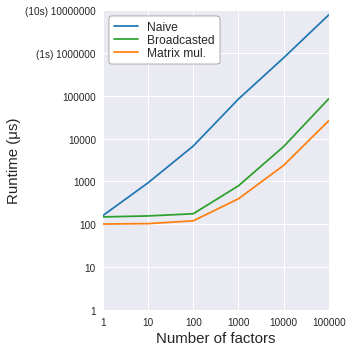

In [114]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(n_factor_values, naive_times, color='tab:blue', label='Naive')
ax.plot(n_factor_values, broadcast_times, color='tab:green', label='Broadcasted')
ax.plot(n_factor_values, matmul_times, color='tab:orange', label='Matrix mul.')
ax.set_xscale('log')
ax.set_xticks(n_factor_values)
ax.set_xticklabels(n_factor_values)
ax.set_xlim(1, n_factor_values[-1])
ax.set_xlabel('Number of factors', fontsize=15)

ax.set_yscale('log')
ax.set_yticks(10**np.arange(8))
ax.set_yticklabels(list(10**np.arange(6)) + ['(1s) 1000000', '(10s) 10000000'])
ax.set_ylim(1, 1e7)
ax.set_ylabel('Runtime (μs)', fontsize=15)

ax.legend(**legend_opts)

plt.tight_layout()
plt.show()
fig.savefig('viz/multi_naive_broadcasted_matmul.png')

Time profile of broadcasted version

In [138]:
%lprun -f broadcast_gradient_descent broadcast_gradient_descent(true_scores, 1, 100000)

In [139]:
%lprun -f matmul_gradient_descent matmul_gradient_descent(true_scores, 1, 100000)

### Memory profiling

In [0]:
np.save('viz/true_scores.npy', true_scores)

# Batch GD using multi factor

In [71]:
def batch_gd_multi(season_scores, skater_order=None, init_seed=42,
             alpha=0.0005, n_iter=1000, n_factors = 1,
             log_iter=False, log_every=10, additional_iter=range(1, 10),
             return_rmse=False):
    '''
    Run gradient descent on some season scores table (long format)
    Return skater and event scores (along with final RMSE and other intermediate values if needed)'''
    
    # Convert long table to pivot table
    season_pivot = pd.pivot_table(season_scores[['name', 'event', 'score']], values='score', index='name', columns='event')
    
    # Modify skater position in pivot table (for aesthetic value only)
    if skater_order is not None:
        season_pivot = season_pivot.loc[skater_order]
        
    # Store skater and event names to retrieve later
    skater_names = list(season_pivot.index)
    event_names = list(season_pivot.columns)
    
    # Convert pivot table to numpy array
    true_scores = season_pivot.values

    # Step 1: Initialize baseline score, and scores of all factors
    random_state = np.random.RandomState(init_seed)
    baseline = random_state.random_sample()   
    event_scores = random_state.random_sample((n_factors, len(event_names)))
    skater_scores = random_state.random_sample((len(skater_names), n_factors))        
    
    # Different lists to contain intermediate values if logging is enabled
    skater_scores_log = []
    event_scores_log = []
    baseline_log = []
    rmse_log = []
    residual_log = []
    iter_log = []
    
    # Step 2: repeat until convergence
    for i in range(n_iter):
        # a. Calculate residual for every event-skater pair
        predicted_scores = skater_scores @ event_scores + baseline
        residuals = predicted_scores - true_scores
        
        # Log intermediate values at certain iterations if logging is enabled
        if log_iter and (i%log_every==0 or (i in additional_iter)):            
            iter_log.append(i)
            skater_scores_log.append(pd.DataFrame(skater_scores, index=skater_names))
            event_scores_log.append(pd.DataFrame(event_scores.T, index=event_names))
            baseline_log.append(baseline)
            residual_log.append(residuals)
            rmse = np.sqrt(np.nanmean(residuals**2))
            rmse_log.append(rmse)
    
        # b. Calculate baseline gradient and update baseline score
        baseline_gradient = np.nansum(residuals)
        baseline = baseline - alpha * baseline_gradient
        
        # c-i: Calculate gradients for all factors
        residuals = np.nan_to_num(residuals)

        # 2c-i: Calculate gradients for all factors
        event_gradients = skater_scores.T @ np.nan_to_num(residuals)
        skater_gradients = np.nan_to_num(residuals) @ event_scores.T
        
        # 2c-ii: Update latent scores for all factors
        event_scores = event_scores - alpha * event_gradients
        skater_scores = skater_scores - alpha * skater_gradients
        
        # Print difference in RMSE for last two iterations
        if i == (n_iter-1):
            rmse_old = np.sqrt(np.nanmean(residuals**2))
            residuals = skater_scores @ event_scores + baseline - true_scores
            rmse_new = np.sqrt(np.nanmean(residuals**2))
            print(f'Alpha: {alpha}, Iter: {n_iter}, Last RMSE: {round(rmse_new, 2)}, Delta RMSE: {round(rmse_new - rmse_old, 10)}')
    
    # Collect logs together in one list
    log = [iter_log, true_scores, skater_names, event_names, skater_scores_log, event_scores_log, baseline_log, residual_log, rmse_log]

    # Put event and skater scores back into Series form with names added
    skater_scores = pd.DataFrame(skater_scores, index=skater_names)
    event_scores = pd.DataFrame(event_scores.T, index=event_names)
    
    if log_iter:
        return baseline, event_scores, skater_scores, log
    elif return_rmse:
        return baseline, event_scores, skater_scores, rmse_new
    else:
        return baseline, event_scores, skater_scores

Run gradient descent for multi-factor model with 5 factors and 151 iterations, log intermediate values, and plot animated dashboard during the run

In [72]:
# Get skater order from hybrid model example to display in dashboard
example_skater_order = np.load('viz/example_skater_order.npy')
baseline, event_scores, skater_scores, [iter_log, true_scores, skater_names, event_names, skater_scores_log, event_scores_log, baseline_log, residual_log, rmse_log] = batch_gd_multi(season_scores, 
skater_order=example_skater_order, alpha=0.0005, n_iter=151, n_factors=5,
log_iter=True, log_every=5, additional_iter=list(range(16)) + list(range(10, 51, 5)))

Alpha: 0.0005, Iter: 151, Last RMSE: 2.41, Delta RMSE: 1.2711868745


In [75]:
def update(i, fig, ax, axr, verbose=False):
    if verbose:
        print(i, end=' ')
    
    fig.suptitle(f'Iteration {iter_log[i]}\nα = 0.0005', x=0.3, y=0.95, va='bottom', ha='center', fontsize=20)
    residuals = residual_log[i]
    ax.imshow(-residuals, cmap='coolwarm', vmin=-30, vmax=30, aspect='auto') # Neagtive residual: red, positive: blue
    ax.set_yticklabels(skater_scores_log[i].applymap('{:.2f}'.format).apply(lambda x: '  '.join(x), axis=1))
    ax.set_xticklabels(event_scores_log[i].applymap('{:.2f}'.format).apply(lambda x: '\n'.join(x), axis=1),
                       fontsize=10) 
    baseline_text.set_text('{0:.2f}'.format(baseline_log[i]))
    
    if i == 0:
        axr.plot(iter_log[i], rmse_log[i], '.', color='tab:brown', clip_on=False)
    if i >= 1:
        axr.plot(iter_log[i-1:i+1], rmse_log[i-1:i+1], '.-', color='tab:brown', clip_on=False)

0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 0 

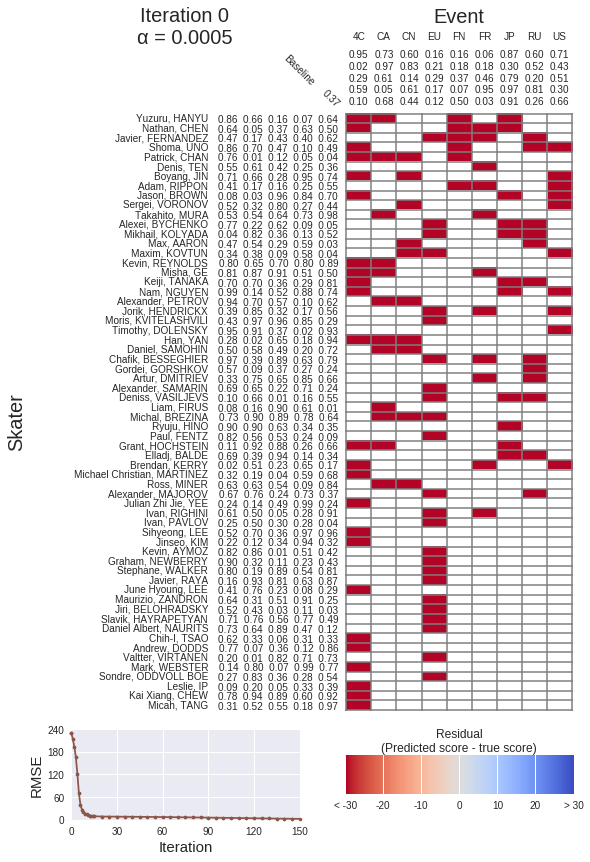

In [76]:
# Set up figure grid
fig = plt.figure(figsize=(9, 13))
grid = plt.GridSpec(20, 2, hspace=1)

# Set up heat map of residuals
ax = fig.add_subplot(grid[:-3, 1])
ax.set_xticks(np.arange(-.5, len(event_names), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(skater_names), 1), minor=True)
ax.grid(which='minor', color='tab:gray', ls='-', lw=1.5)
ax.grid(None, which='major')
ax.set_xlim(-0.54, len(event_names)-0.45)
ax.set_xticks(range(len(event_names)))
ax.xaxis.tick_top()
ax.set_ylim(-0.6, len(skater_names)-0.45)
ax.set_yticks(range(len(skater_names)))
ax.set_facecolor('white')


for i, skater in enumerate(skater_names):
    ax.text(x=-6, y=i-0.3, s=skater, ha='right')
for i, event in enumerate(event_names):
    ax.text(x=i, y=len(skater_names)+7, s=event, va='bottom', ha='center')
ax.text(x=-1.7, y=len(skater_names)+2.3, s='Baseline', rotation=-45, va='bottom', ha='right')
baseline_text = ax.text(x=-0.7, y=len(skater_names), s='', rotation=-45, va='bottom', ha='right')

ax.text(x=-14, y=len(skater_names)/2, s='Skater', rotation=90, fontsize=20)
ax.text(x=4, y=len(skater_names)+9, s='Event', fontsize=20, ha='center')

# Set up RMSE plot
axr = fig.add_subplot(grid[-3:, 0])
axr.set_xlim(0, iter_log[-1])
axr.set_xticks(range(0, iter_log[-1]+1, 30))
axr.set_xlabel('Iteration', fontsize=15)
axr.set_ylim(0, 240)
axr.set_yticks(np.arange(0, 241, 60))
axr.set_ylabel('RMSE', fontsize=15)

# Plot colorbar of residual
axc = fig.add_subplot(grid[-3:, 1])
cmap = plt.cm.get_cmap('coolwarm')
colors = cmap(np.arange(cmap.N, -1, -1)) # Plot colorbar from red to blue (not blue to red)
axc.imshow([colors], extent=[-30, 30, 0, 10])
axc.xaxis.set_label_position('top') 
axc.set_xlabel('Residual\n(Predicted score - true score)', fontsize=12)
axc.set_xticklabels(['< -30', '-20', '-10', '0', '10', '20', '> 30'])
axc.set_yticks([])

anim = FuncAnimation(fig, lambda i: update(i, fig, ax, axr, verbose=True), 
                     frames=len(iter_log), interval=500)

anim.save('viz/batch_anim_multi.gif', writer='imagemagick')

# Rank skaters using individuals factors

In [77]:
# Run 5-factor model to get latent skater scores
n_factors = 5
baseline, event_scores, skater_scores, rmse = batch_gd_multi(season_scores, 
skater_order=example_skater_order, alpha=0.0005, n_iter=1000, n_factors=n_factors, return_rmse=True)

Alpha: 0.0005, Iter: 1000, Last RMSE: 0.03, Delta RMSE: 0.0144939979


In [78]:
# Get skater rankings and Kendall's tau if each factor were to be used separately to rank skaters
skater_rankings_by_factor = []
taus_by_factor = []
for i in range(n_factors):
    skater_ranking, world_ranking = return_ranking(skater_scores[i], world_scores)
    skater_rankings_by_factor.append(skater_ranking)
    taus_by_factor.append(calculate_kendall_tau(skater_ranking, world_ranking))

There are 200 concordant_pairs out of 276 pairs
There are 141 concordant_pairs out of 276 pairs
There are 160 concordant_pairs out of 276 pairs
There are 163 concordant_pairs out of 276 pairs
There are 188 concordant_pairs out of 276 pairs


In [79]:
# Calculate pairwise Kendall's tau between any 2 factors after running multi-factor model
pairwise_kendall_tau = np.zeros((n_factors, n_factors))
for i in range(n_factors):
    for j in range(i, n_factors):
        tau = calculate_kendall_tau(skater_rankings_by_factor[i], skater_rankings_by_factor[j])
        pairwise_kendall_tau[i, j] = tau
        pairwise_kendall_tau[j, i] = tau

There are 276 concordant_pairs out of 276 pairs
There are 123 concordant_pairs out of 276 pairs
There are 118 concordant_pairs out of 276 pairs
There are 131 concordant_pairs out of 276 pairs
There are 190 concordant_pairs out of 276 pairs
There are 276 concordant_pairs out of 276 pairs
There are 137 concordant_pairs out of 276 pairs
There are 92 concordant_pairs out of 276 pairs
There are 127 concordant_pairs out of 276 pairs
There are 276 concordant_pairs out of 276 pairs
There are 161 concordant_pairs out of 276 pairs
There are 156 concordant_pairs out of 276 pairs
There are 276 concordant_pairs out of 276 pairs
There are 133 concordant_pairs out of 276 pairs
There are 276 concordant_pairs out of 276 pairs


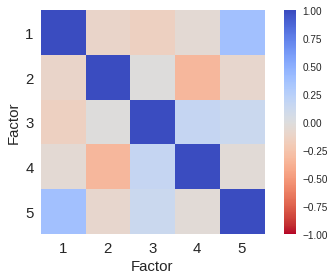

In [80]:
# Plot heat map of Kendall's tau correlation between any two factors
plt.imshow(pairwise_kendall_tau, cmap='coolwarm_r', vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(range(n_factors), range(1, n_factors+1), fontsize=15)
plt.xlabel('Factor', fontsize=15)
plt.yticks(range(n_factors), range(1, n_factors+1), fontsize=15)
plt.ylabel('Factor', fontsize=15)
plt.grid(None)

plt.tight_layout()
plt.savefig('viz/factor_pairwise_kendall.png')

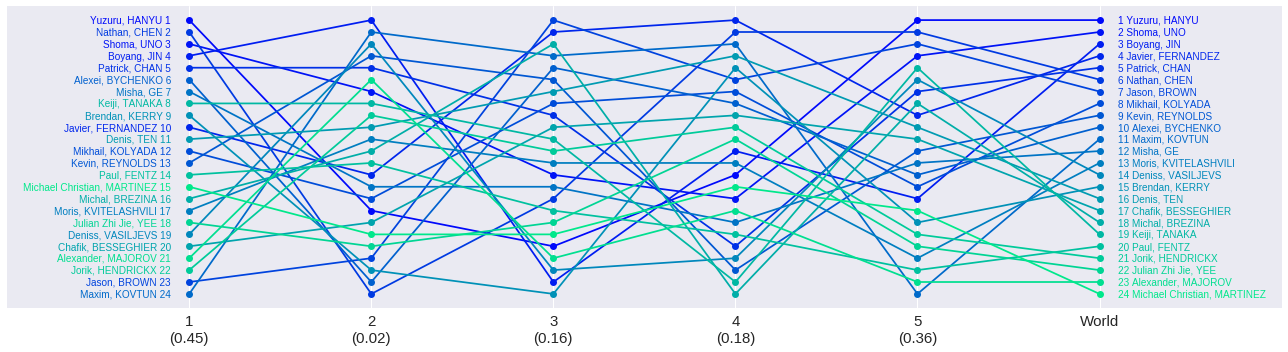

In [81]:
# Plot predicted ranking using individual factor compared to world ranking
skater_rankings_by_factor.append(world_ranking)
ranking_labels = [str(factor) + '\n' + f'({tau:.2f})' for factor, tau in zip(list(range(1, n_factors+1)), taus_by_factor)] + ['World']

fig, ax = plt.subplots(figsize=(18, 5))
plot_multiple_rankings(fig, ax, skater_rankings_by_factor, ranking_labels,
                       filepath='viz/rank_each_factor.png', xfontsize=15, zorder=None)